# End-to-End Example training object detection model using NVIDIA Pytorch Container from NGC
 ----

Note this Object Detection demo is based on https://github.com/pytorch/vision/tree/v0.11.3

This notebook walks you each step to train a model using containers from the NGC Catalog. We chose the GPU optimized Pytorch container as an example. The basics of working with docker containers apply to all NGC containers.

We will show you how to:

* Install the Docker Engine on your system
* Pull a Pytorch container from the NGC Catalog using Docker
* Run the Pytorch container using Docker
* Part 2 : Preprocess the Satellite imagery object detection dataset using the SAHI library
* Part 3 : Execute training a object detection on satellite imagery using TensorFlow and Jupyter Notebook
* Part 4 : Run inference on a trained object detection model using the SAHI library

Let's get started!

---

### 1. Install the Docker Engine
Go to https://docs.docker.com/engine/install/ to install the Docker Engine on your system.


### 2. Download the TensorFlow container from the NGC Catalog 

Once the Docker Engine is installed on your machine, visit https://ngc.nvidia.com/catalog/containers and search for the TensorFlow container. Click on the TensorFlow card and copy the pull command.
UPDATE IMG
<img src="https://raw.githubusercontent.com/kbojo/images/master/NGC.png">

Open the command line of your machine and past the pull command into your command line. Execute the command to download the container. 

```$ docker pull nvcr.io/nvidia/pytorch:21.11-py3```
    
The container starts downloading to your computer. A container image consists of many layers; all of them need to be pulled. 

### 3. Run the TensorFlow container image

Once the container download is completed, run the following code in your command line to run and start the container:

```$ docker run -it --gpus all  -p 8888:8888 -v $PWD:/projects --network=host nvcr.io/nvidia/pytorch:21.11-py3```
UPDATE IMG
<img src="https://raw.githubusercontent.com/kbojo/images/master/commandline1.png">

### 4. Install Jupyter lab and open a notebook

Within the container, run the following commands:

```pip install torchvision==0.11.3 jupyterlab```

```jupyter lab --ip=0.0.0.0 --port=8888 --allow-root```

Open up your favorite browser and enter: http://localhost:8888/?token=*yourtoken*.
UPDATE IMG
<img src="https://raw.githubusercontent.com/kbojo/images/master/commandline2.png">

You should see the Jupyter Lab application. Click on the plus icon to launch a new Python 3 noteb
ook.

Follow along with the image classification with the TensorFlow example provided below.

In [4]:
%%capture
!pip install cython pycocotools matplotlib terminaltables


# TLDR; run training job on 8 GPUS
The below cell will run a multi-gpu training job. This job will train an object detection model (faster-rcnn) on a dataset of satellite imagery images that contain 61 classes of objects
* Change `nproc_per_node` argument to specify the number of GPUs available on your server

In [ ]:
!torchrun --nproc_per_node=8 detection/train.py\
    --dataset coco --data-path=/run/determined/workdir/shared_fs/data/xview_dataset/ --model fasterrcnn_resnet50_fpn --epochs 26\
    --lr-steps 16 22 --aspect-ratio-group-factor 3

### 5. Preprocess Satellite Imagery Dataset with Pytorch
* TODO

In [1]:
# TODO 

### 6. Object Detection on Satellite Imagery with Pytorch (Single GPU)
Follow and Run the code to train a Faster RCNN FPN (Resnet50 backbone) that classifies images of clothing. 

In [6]:
import sys
sys.path.insert(0,'detection')

In [7]:
# Import python dependencies
import datetime
import os
import time

import torch
import torch.utils.data
import torchvision
import torchvision.models.detection
import torchvision.models.detection.mask_rcnn

from coco_utils import get_coco, get_coco_kp

from group_by_aspect_ratio import GroupedBatchSampler, create_aspect_ratio_groups
from engine import train_one_epoch, evaluate

import presets
import utils
from coco_utils import get_coco, get_coco_kp
from train import get_dataset, get_transform
from group_by_aspect_ratio import GroupedBatchSampler, create_aspect_ratio_groups
from engine import train_one_epoch, evaluate
from models import build_frcnn_model
from PIL import Image
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from collections import OrderedDict
from tqdm import tqdm
from vis_utils import load_determined_state_dict, visualize_pred, visualize_gt, predict
import numpy as np

import matplotlib.pyplot as plt

In [8]:
output_dir='output'
data_path='/run/determined/workdir/shared_fs/data/xview_dataset/'
dataset_name='coco'
model_name='fasterrcnn_resnet50_fpn'
device='cpu'
batch_size=8
epochs=26
workers=4
lr=0.02
momentum=0.9
weight_decay=1e-4
lr_scheduler='multisteplr'
lr_step_size=8
lr_steps=[16, 22]
lr_gamma=0.1
print_freq=20
resume=False
start_epoch=0
aspect_ratio_group_factor=3
rpn_score_thresh=None
trainable_backbone_layers=None
data_augmentation='hflip'
pretrained=True
test_only=False
sync_bn=False

In [9]:
# Import the dataset.
# Data loading code
print("Loading data")

dataset, num_classes = get_dataset(dataset_name, "train", get_transform(True, data_augmentation),
                                   data_path)
dataset_test, _ = get_dataset(dataset_name, "val", get_transform(False, data_augmentation), data_path)
print(dataset.num_classes)
print("Creating data loaders")
train_sampler = torch.utils.data.RandomSampler(dataset)
test_sampler = torch.utils.data.SequentialSampler(dataset_test)
group_ids = create_aspect_ratio_groups(dataset, k=aspect_ratio_group_factor)
train_batch_sampler = GroupedBatchSampler(train_sampler, group_ids, batch_size)
train_batch_sampler = torch.utils.data.BatchSampler(
            train_sampler, batch_size, drop_last=True)

data_loader = torch.utils.data.DataLoader(
    dataset, batch_sampler=train_batch_sampler, num_workers=workers,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1,
    sampler=test_sampler, num_workers=0,
    collate_fn=utils.collate_fn)

Loading data
loading annotations into memory...
Done (t=2.94s)
creating index...
index created!
self.catIdtoCls:  {0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 5: 6, 6: 7, 7: 8, 8: 9, 9: 10, 10: 11, 11: 12, 12: 13, 13: 14, 14: 15, 15: 16, 16: 17, 17: 18, 18: 19, 19: 20, 20: 21, 21: 22, 22: 23, 23: 24, 24: 25, 25: 26, 26: 27, 27: 28, 28: 29, 29: 30, 30: 31, 31: 32, 32: 33, 33: 34, 34: 35, 35: 36, 36: 37, 37: 38, 38: 39, 39: 40, 40: 41, 41: 42, 42: 43, 43: 44, 44: 45, 45: 46, 46: 47, 47: 48, 48: 49, 49: 50, 50: 51, 51: 52, 52: 53, 53: 54, 54: 55, 55: 56, 56: 57, 57: 58, 58: 59, 59: 60}
self.num_classes:  61
{1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 12: 11, 13: 12, 14: 13, 15: 14, 16: 15, 17: 16, 18: 17, 19: 18, 20: 19, 21: 20, 22: 21, 23: 22, 24: 23, 25: 24, 26: 25, 27: 26, 28: 27, 29: 28, 30: 29, 31: 30, 32: 31, 33: 32, 34: 33, 35: 34, 36: 35, 37: 36, 38: 37, 39: 38, 40: 39, 41: 40, 42: 41, 43: 42, 44: 43, 45: 44, 46: 45, 47: 46, 48: 47, 49: 48, 50: 49, 51: 50, 52: 51, 53: 

In [10]:
# Getting three examples from the test dataset
inds_that_have_boxes = []
test_images = list(data_loader_test)
for ind,(im,targets) in tqdm(enumerate(test_images),total=len(list(data_loader_test))):
    # print(ind,targets)
    if targets[0]['boxes'].shape[0]>0:
        # print(targets[0]['boxes'].shape[0])
        # print(ind,targets)
        inds_that_have_boxes.append(ind)

images_t_list=[]
targets_t_list=[]
for ind in tqdm(range(3)):
    im,targets = test_images[ind]
    images_t_list.append(im[0])
    targets_t_list.append(targets[0])

100%|██████████| 3/3 [00:00<00:00, 41803.69it/s]


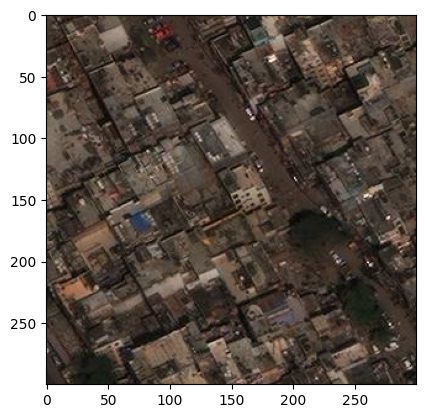

In [11]:
# Let's have a look at one of the images. The following code visualizes the images using the matplotlib library.
im = Image.fromarray((255.*images_t_list[0].cpu().permute((1,2,0)).numpy()).astype(np.uint8))
plt.imshow(im)
plt.show()

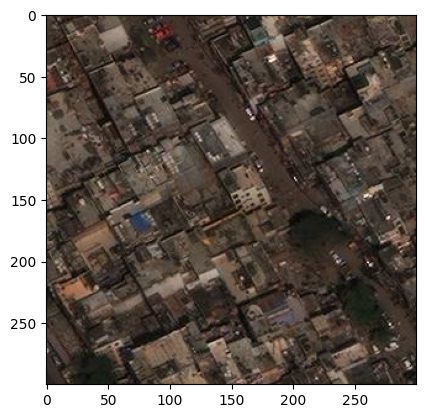

Num GT Boxes:  66


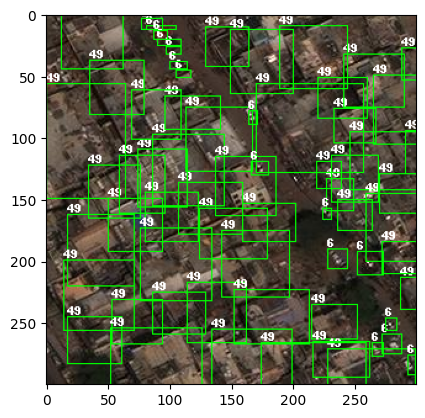

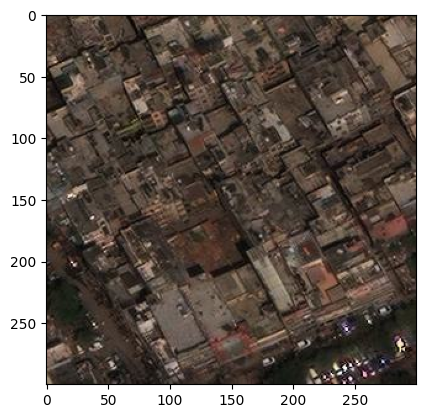

Num GT Boxes:  72


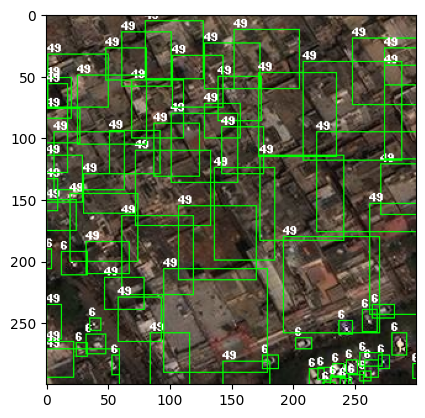

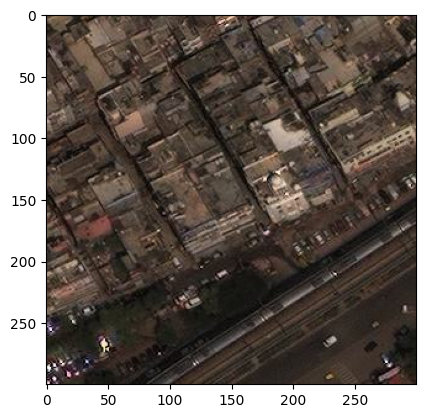

Num GT Boxes:  67


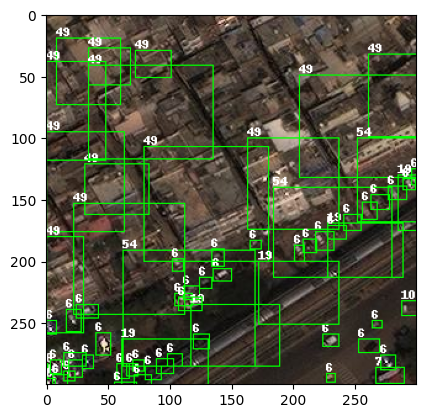

In [12]:
# Let's look again at the first three images, but this time with the class names.

for i,t in zip(images_t_list,targets_t_list):
    im = Image.fromarray((255.*i.cpu().permute((1,2,0)).numpy()).astype(np.uint8))
    plt.imshow(im)
    plt.show()
    im = visualize_gt(i,t)
    plt.imshow(im)
    plt.show()

In [13]:
# Let's build the model:
print("Creating model")
print("Number of classes: ",dataset.num_classes)
model = build_frcnn_model(num_classes=dataset.num_classes)
_=model.to('cpu')



Creating model
Number of classes:  61
Loading pretrained model...


In [ ]:
# Compile the model:
# Define loss function, optimizer, and metrics.
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params, lr=lr, momentum=momentum, weight_decay=weight_decay)

lr_scheduler = lr_scheduler.lower()
if lr_scheduler == 'multisteplr':
    lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, 
                                                        milestones=lr_steps, 
                                                        gamma=lr_gamma)
elif lr_scheduler == 'cosineannealinglr':
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
else:
    raise RuntimeError("Invalid lr scheduler '{}'. Only MultiStepLR and CosineAnnealingLR "
                       "are supported.".format(args.lr_scheduler))


In [ ]:
# Train the model:
# Let's train 1 epoch. After every epoch, training time, loss, and accuracy will be displayed.
print("Start training")
start_time = time.time()
for epoch in range(start_epoch, epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq)
    lr_scheduler.step()
    if output_dir:
        checkpoint = {
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'lr_scheduler': lr_scheduler.state_dict(),
            'args': args,
            'epoch': epoch
        }
        utils.save_on_master(
            checkpoint,
            os.path.join(output_dir, 'model_{}.pth'.format(epoch)))
        utils.save_on_master(
            checkpoint,
            os.path.join(output_dir, 'checkpoint.pth'))

    # evaluate after every epoch
    evaluate(model, data_loader_test, device=device)

total_time = time.time() - start_time
total_time_str = str(datetime.timedelta(seconds=int(total_time)))
print('Training time {}'.format(total_time_str))

In [22]:
# Let's see how the model performs on the test data:
ckpt = torch.load('/run/determined/workdir/e2e_blogposts/ngc_blog/model_18.pth',map_location='cpu')
model.load_state_dict(ckpt['model'])
_=model.eval()


Num GT Boxes:  66
Num Pred Boxes:  100


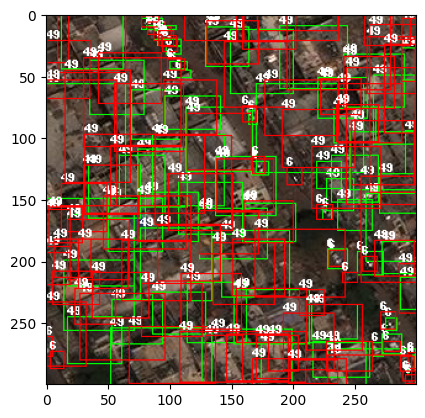

Num GT Boxes:  72
Num Pred Boxes:  100


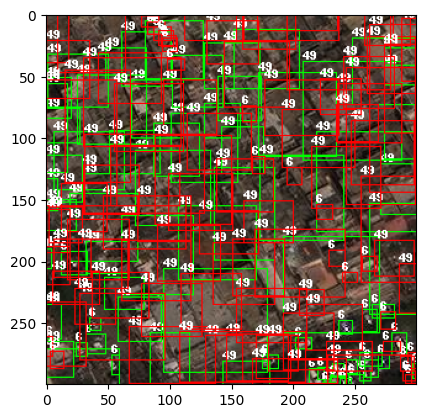

Num GT Boxes:  67
Num Pred Boxes:  100


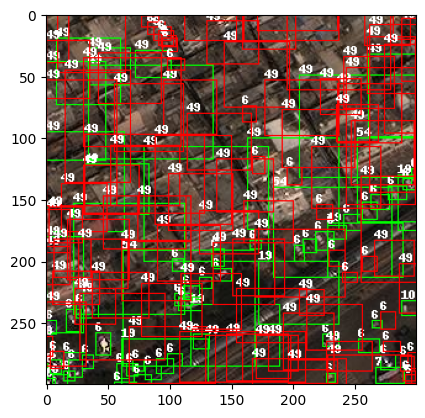

In [23]:
_=predict(model,images_t_list,targets_t_list)